In [5]:
!pip install pymorphy3 -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.8/53.8 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 59.5 MB/s eta 0:00:00


Домашку будет легче делать в колабе (убедитесь, что у вас runtype с gpu).

In [48]:
# import tensorflow as tf
import re
import numpy as np
import pandas as pd
import pymorphy3 as pm
import gensim
from string import punctuation
from sklearn.model_selection import train_test_split
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_distances
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

from IPython.display import Image
from IPython.core.display import HTML
%matplotlib inline

In [2]:
import os
os.environ["KERAS_BACKEND"] = "torch"
# os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"

import torch
# torch.set_default_device('cpu')

import keras
print(keras.__version__)

3.5.0


In [3]:
morph = pm.MorphAnalyzer()

# Задание 1 (3 балла)

Обучите word2vec модели с негативным семплированием (cbow и skip-gram) аналогично тому, как это было сделано в семинаре. Вам нужно изменить следующие пункты:
1) добавьте лемматизацию в предобработку (любым способом)  
2) измените размер окна в большую или меньшую сторону
3) измените размерность итоговых векторов

Выберете несколько не похожих по смыслу слов (не таких как в семинаре), и протестируйте полученные эмбединги (найдите ближайшие слова и оцените качество, как в семинаре).
Постарайтесь обучать модели как можно дольше и на как можно большем количестве данных. (Но если у вас мало времени или ресурсов, то допустимо взять поменьше данных и поставить меньше эпох)

In [6]:
wiki = open('wiki_data.txt').read().split('\n')

In [4]:
def preprocess(text):
    tokens = re.sub('#+', ' ', text.lower()).split()
    tokens = [token.strip(punctuation) for token in tokens]
    tokens = [token for token in tokens if token]
    tokens = [morph.parse(tok)[0].normal_form for tok in tokens]
    return tokens

In [7]:
vocab = Counter()

for text in wiki:
    vocab.update(preprocess(text))

In [8]:
filtered_vocab = set()

for word in vocab:
    if vocab[word] > 30:
        filtered_vocab.add(word)

In [9]:
word2id = {'PAD':0}

for word in filtered_vocab:
    word2id[word] = len(word2id)

id2word = {i:word for word, i in word2id.items()}

vocab_size = len(id2word)

In [10]:
sentences = []

for text in wiki:
    tokens = preprocess(text)
    if not tokens:
        continue
    ids = [word2id[token] for token in tokens if token in word2id]
    sentences.append(ids)

In [11]:
# skip gram
def gen_batches_sg(sentences, window = 5, batch_size=1000):

    # параметр window задает его целиком
    # нам нужно поделить его пополам на левую и правую часть
    # когда делится неровно, то левая часть больше на 1
    left_context_length = (window/2).__ceil__() # округлить в большую сторону
    right_context_length = window // 2 # округлить в меньшую сторону

    while True:
        X_target = []
        X_context = []
        y = []

        for sent in sentences:
            for i in range(len(sent)-1):
                word = sent[i]
                context = sent[max(0, i-left_context_length):i] + sent[i+1:i+right_context_length]
                for context_word in context:
                    X_target.append(word)
                    X_context.append(context_word)
                    y.append(1)

                    X_target.append(word)
                    X_context.append(np.random.randint(vocab_size))
                    y.append(0)

                    if len(X_target) >= batch_size:
                        X_target = np.array(X_target)
                        X_context = np.array(X_context)
                        y = np.array(y)
                        yield ((X_target, X_context), y)
                        X_target = []
                        X_context = []
                        y = []

In [12]:
# cbow
def gen_batches_cbow(sentences, window = 5, batch_size=1000):

    # параметр window задает его целиком
    # нам нужно поделить его пополам на левую и правую часть
    # когда делится неровно, то левая часть больше на 1
    left_context_length = (window/2).__ceil__() # округлить в большую сторону
    right_context_length = window // 2 # округлить в меньшую сторону

    while True:
        X_target = []
        X_context = []
        y = []

        for sent in sentences:
            for i in range(len(sent)-1):
                word = sent[i]
                context = sent[max(0, i-left_context_length):i] + sent[i+1:i+right_context_length]

                X_target.append(word)
                X_context.append(context)
                y.append(1)

                X_target.append(np.random.randint(vocab_size))
                X_context.append(context)
                y.append(0)

                if len(X_target) == batch_size:
                    X_target = np.array(X_target)
                    X_context = keras.preprocessing.sequence.pad_sequences(X_context, maxlen=window)
                    y = np.array(y)
                    yield ((X_target, X_context), y)
                    X_target = []
                    X_context = []
                    y = []

In [18]:
# skip gram negative sampling
inputs_target = keras.layers.Input(shape=(1,))
inputs_context = keras.layers.Input(shape=(1,))

embeddings_target = keras.layers.Embedding(input_dim=len(word2id), output_dim=100)(inputs_target, )
embeddings_context = keras.layers.Embedding(input_dim=len(word2id), output_dim=100)(inputs_context, )

target = keras.layers.Flatten()(embeddings_target)
context = keras.layers.Flatten()(embeddings_context)

dot = keras.layers.Dot(1)([target, context])
outputs = keras.layers.Activation(activation='sigmoid')(dot)

model = keras.Model(inputs=[inputs_target, inputs_context],
                       outputs=outputs)

optimizer = keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [19]:
model.fit(gen_batches_sg(sentences[:19000], window=5),
          validation_data=gen_batches_sg(sentences[19000:],  window=5),
          batch_size=1000,
          steps_per_epoch=2000,
          validation_steps=30,
          epochs=20)

Epoch 1/20
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 20s 10ms/step - accuracy: 0.7113 - loss: 0.5787 - val_accuracy: 0.7955 - val_loss: 0.4747
Epoch 2/20
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 22s 11ms/step - accuracy: 0.8088 - loss: 0.4321 - val_accuracy: 0.8058 - val_loss: 0.4354
Epoch 3/20
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 19s 9ms/step - accuracy: 0.8099 - loss: 0.4314 - val_accuracy: 0.8110 - val_loss: 0.4313
Epoch 4/20
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 18s 9ms/step - accuracy: 0.8120 - loss: 0.4294 - val_accuracy: 0.8172 - val_loss: 0.4303
Epoch 5/20
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 18s 9ms/step - accuracy: 0.8225 - loss: 0.4092 - val_accuracy: 0.8242 - val_loss: 0.3971
Epoch 6/20
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 18s 9ms/step - accuracy: 0.8161 - loss: 0.4173 - val_accuracy: 0.8154 - val_loss: 0.4184
Epoch 7/20
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 19s 9ms/step - accuracy: 0.8281 - loss: 0.3960 - val_accuracy: 0.8150 - val_loss: 0.4208
Epoch 8/20
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 18s 9ms/step - accuracy: 0.8266 - loss:

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


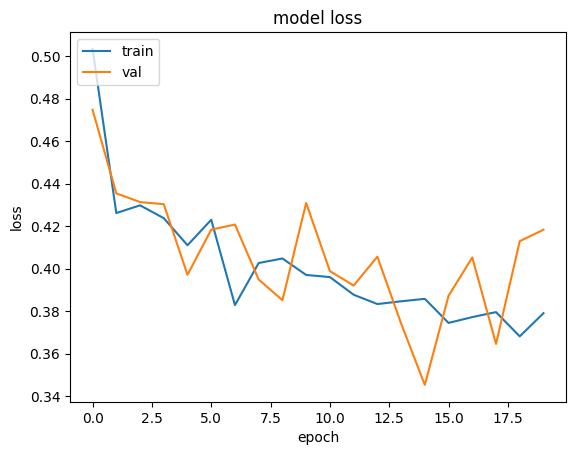

In [20]:
print(model.history.history.keys())
# summarize history for accuracy
plt.plot(model.history.history['loss'])
plt.plot(model.history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [21]:
embeddings = model.layers[2].get_weights()[0]

In [22]:
def most_similar(word, embeddings):
    similar = [id2word[i] for i in
               cosine_distances(embeddings[word2id[word]].reshape(1, -1), embeddings).argsort()[0][:10]]
    return similar

In [23]:
most_similar('кошка', embeddings)

['кошка',
 'овощ',
 'выращивать',
 'употреблять',
 'раковина',
 'заражение',
 'прозрачный',
 'добавлять',
 'сок',
 'рецептор']

In [24]:
most_similar('дружба', embeddings)

['дружба',
 'арагон',
 'самойлов',
 'чей',
 'храбрость»',
 'даровать',
 'станислав',
 'отто',
 'адольф',
 'трудовой']

In [31]:
# cbow negative sampling
inputs_target = keras.layers.Input(shape=(1,))
inputs_context = keras.layers.Input(shape=(5,))

embeddings_target = keras.layers.Embedding(input_dim=len(word2id), output_dim=100)(inputs_target, )
embeddings_context = keras.layers.Embedding(input_dim=len(word2id), output_dim=100)(inputs_context, )

target = keras.layers.Flatten()(embeddings_target)
context = keras.layers.Lambda(lambda x: x.sum(axis=1))(embeddings_context)
dot = keras.layers.Dot(1)([target, context])

# полученную близость нужно преобразовать в вероятность
# когда она одна используется не софтмакс и сигмоида
outputs = keras.layers.Activation(activation='sigmoid')(dot)

model = keras.Model(inputs=[inputs_target, inputs_context],
                       outputs=outputs)

optimizer = keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [33]:
model.build([(None, 1), (None, 5)])

model.fit(gen_batches_cbow(sentences[:19000], window=5),
          validation_data=gen_batches_cbow(sentences[19000:],  window=5),
          batch_size=1000,
          steps_per_epoch=2000,
          validation_steps=30,
          epochs=20)

Epoch 1/20
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 33s 17ms/step - accuracy: 0.9221 - loss: 0.1932 - val_accuracy: 0.8998 - val_loss: 0.2593
Epoch 2/20
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 23s 12ms/step - accuracy: 0.9254 - loss: 0.1861 - val_accuracy: 0.9024 - val_loss: 0.2535
Epoch 3/20
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 22s 11ms/step - accuracy: 0.9218 - loss: 0.1939 - val_accuracy: 0.8934 - val_loss: 0.2750
Epoch 4/20
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 23s 12ms/step - accuracy: 0.9247 - loss: 0.1884 - val_accuracy: 0.9042 - val_loss: 0.2428
Epoch 5/20
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 24s 12ms/step - accuracy: 0.9225 - loss: 0.1925 - val_accuracy: 0.8901 - val_loss: 0.2972
Epoch 6/20
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 23s 11ms/step - accuracy: 0.9286 - loss: 0.1796 - val_accuracy: 0.8889 - val_loss: 0.2934
Epoch 7/20
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 23s 11ms/step - accuracy: 0.9260 - loss: 0.1851 - val_accuracy: 0.8808 - val_loss: 0.3190
Epoch 8/20
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 22s 11ms/step - accuracy: 0.9282 -

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


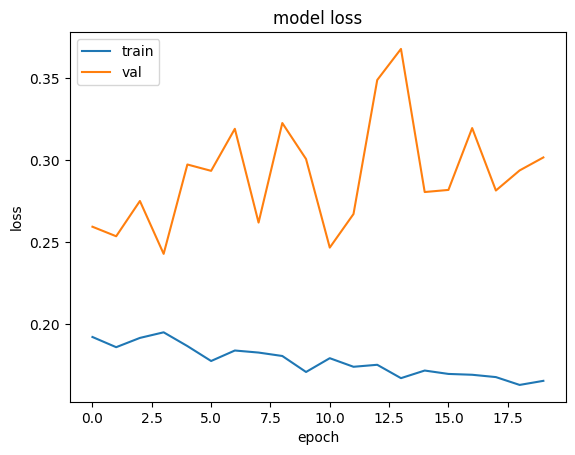

In [34]:
print(model.history.history.keys())
# summarize history for accuracy
plt.plot(model.history.history['loss'])
plt.plot(model.history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [35]:
embeddings = model.layers[2].get_weights()[0]

In [36]:
most_similar('кошка', embeddings)

['кошка',
 'разведение',
 'крокодил',
 'варан',
 'ездовой',
 'торт',
 'пятнистый',
 'лягушка',
 'баттлера',
 'щука']

In [37]:
most_similar('дружба', embeddings)

['дружба',
 'покровительство',
 'демон',
 'ленин',
 'ефремов',
 'благородство',
 'соперничество',
 'господин',
 'мужество',
 'отечество']

Судя по графикам и похожим словам и там, и там получилось не очень хорошо, скорее всего, как минимум, стоит увеличить steps_per_epoch и посмотреть, что получится, но у меня не хватило времени :(

# Задание 2 (2 балла)

Обучите 1 word2vec и 1 fastext модель в gensim. В каждой из модели нужно задать все параметры, которые мы разбирали на семинаре. Заданные значения должны отличаться от дефолтных и от тех, что мы использовали на семинаре.

In [39]:
wiki = open('wiki_data.txt', encoding='utf8').read().split('\n')
texts = [preprocess(text) for text in wiki]

In [41]:
w2v = gensim.models.Word2Vec(texts,
                             vector_size=100,
                             min_count=20,
                             max_vocab_size=1000000,
                             window=10,
                             epochs=8,
                             hs=0,
                             negative=10,
                             sample=1e-3,
                             sg=0)

In [42]:
w2v.wv.most_similar('кошка')

[('дикобраз', 0.7373982071876526),
 ('охота', 0.7352582812309265),
 ('зверь', 0.7312724590301514),
 ('охотиться', 0.7282750010490417),
 ('кролик', 0.7249694466590881),
 ('кошачий', 0.7226378917694092),
 ('дикий', 0.7112734317779541),
 ('собака', 0.7070069313049316),
 ('хищный', 0.7055281400680542),
 ('хищник', 0.704936146736145)]

In [43]:
ft = gensim.models.FastText(texts, min_n=3, max_n=12)

In [44]:
ft.wv.most_similar('кошка')

[('косатка', 0.9671851992607117),
 ('кормушка', 0.9512814283370972),
 ('кока', 0.950646698474884),
 ('шашка', 0.9496977925300598),
 ('блошка', 0.9470425844192505),
 ('кошечка', 0.9465885758399963),
 ('клюшка', 0.9442136883735657),
 ('вашка', 0.9441648125648499),
 ('колюшка', 0.9413336515426636),
 ('шишка', 0.9412825107574463)]

# Задание 3 (3 балла)

Используя датасет для классификации (labeled.csv), обучите классификатор на базе эмбеддингов. Оцените качество на отложенной выборке.   
В качестве эмбеддинг модели вы можете использовать одну из моделей обученных в предыдущем задании или использовать одну из предобученных моделей с rusvectores (удостоверьтесь что правильно воспроизводите предобработку в этом случае!)  
Для того, чтобы построить эмбединг целого текста, усредните вектора отдельных слов в один общий вектор.
В качестве алгоритма классификации используйте LogisicticRegression (можете попробовать SGDClassifier, чтобы было побыстрее)  
F1 мера должна быть выше 20%.

In [50]:
data = pd.read_csv('labeled.csv')

In [58]:
train, test = train_test_split(data, test_size=0.05, shuffle=True)
train.reset_index(inplace=True)
test.reset_index(inplace=True)

In [68]:
def text_to_vector(vectorizer, new_text):
    tokens = preprocess(new_text)
    vector = np.zeros(vectorizer.vector_size)
    count = 0
    for token in tokens:
        if token in vectorizer.wv:
            vector += vectorizer.wv[token]
            count += 1
    if count > 0:
        vector /= count
    return vector

In [69]:
X = []
for comment in train['comment'].values:
    X.append(text_to_vector(w2v, comment))
y = train['toxic'].values

In [70]:
classifier = LogisticRegression(solver ="liblinear", penalty="l2")
classifier.fit(X, y)

LogisticRegression(solver='liblinear')

In [71]:
X_test = []
for comment in test['comment'].values:
    X_test.append(text_to_vector(w2v, comment))

preds = classifier.predict(X_test)

In [72]:
print(classification_report(test['toxic'].values, preds, zero_division=0))

              precision    recall  f1-score   support

         0.0       0.79      0.89      0.84       465
         1.0       0.74      0.58      0.65       256

    accuracy                           0.78       721
   macro avg       0.77      0.74      0.75       721
weighted avg       0.78      0.78      0.77       721



# Задание 4 (2 доп балла)

В тетрадку с фастекстом добавьте код для обучения с negative sampling (задача сводится к бинарной классификации) и обучите модель. Проверьте полученную модель на нескольких словах. Похожие слова должны быть похожими по смыслу и по форме.

In [78]:
def tokenize(text):
    tokens = re.sub('#+', ' ', text.lower()).split()
    tokens = [token.strip(punctuation) for token in tokens]
    tokens = [token for token in tokens if token]
    return tokens

In [73]:
def ngrammer(raw_string, n=2):
    ngrams = []
    raw_string = ''.join(['<', raw_string, '>'])
    for i in range(0,len(raw_string)-n+1):
        ngram = ''.join(raw_string[i:i+n])
        if ngram == '<' or ngram == '>': # сами по себе <> как токены не нужны
            continue
        ngrams.append(ngram)
    return ngrams

In [74]:
def split_tokens(tokens, min_ngram_size, max_ngram_size):
    tokens_with_subwords = []
    for token in tokens:
        subtokens = []
        for i in range(min_ngram_size, max_ngram_size+1):
            if len(token) > i:
                subtokens.extend(ngrammer(token, i))
        tokens_with_subwords.append(subtokens)
    return tokens_with_subwords

In [75]:
class SubwordTokenizer:
    def __init__(self, ngram_range=(1,1), min_count=5):
        self.min_ngram_size, self.max_ngram_size = ngram_range
        self.min_count = min_count
        self.subword_vocab = None
        self.fullword_vocab = None
        self.vocab = None
        self.id2word = None
        self.word2id = None

    def build_vocab(self, texts):
        # чтобы построить словарь нужно пройти по всему корпусу и собрать частоты всех уникальных слов и нграммов
        unfiltered_subword_vocab = Counter()
        unfiltered_fullword_vocab = Counter()
        for text in texts:
            tokens = tokenize(text)
            unfiltered_fullword_vocab.update(tokens)
            subwords_per_token = split_tokens(tokens, self.min_ngram_size, self.max_ngram_size)
            for subwords in subwords_per_token:
                # в одном слове могут быть одинаковые нграммы поэтому возьмем только уникальные
                unfiltered_subword_vocab.update(set(subwords))

        self.fullword_vocab = set()
        self.subword_vocab = set()

        # теперь отфильтруем по частоте
        for word, count in unfiltered_fullword_vocab.items():
            if count >= self.min_count:
                self.fullword_vocab.add(word)
        # для нграммов сделаем порог побольше чтобы не создавать слишком много нграммов
        # и учитывать только действительно частотные
        for word, count in unfiltered_subword_vocab.items():
            if count >= (self.min_count * 100):
                self.subword_vocab.add(word)

        # общий словарь
        self.vocab = self.fullword_vocab | self.subword_vocab
        self.id2word = {i:word for i,word in enumerate(self.vocab)}
        self.word2id = {word:i for i,word in self.id2word.items()}

    def subword_tokenize(self, text):
        if self.vocab is None:
            raise AttributeError('Vocabulary is not built!')
        # разбиваем на токены
        tokens = tokenize(text)
        # каждый токен разбиваем на символьные нграммы
        tokens_with_subwords = split_tokens(tokens, self.min_ngram_size, self.max_ngram_size)
        # оставляет только токены и нграммы которые есть в словаре
        only_vocab_tokens_with_subwords = []
        for full_token, sub_tokens in zip(tokens, tokens_with_subwords):
            filtered = []
            if full_token in self.vocab:
                # само слово и нграммы хранятся в одном списке
                # но слово будет всегда первым в списке
                filtered.append(full_token)
            filtered.extend([subtoken for subtoken in set(sub_tokens) if subtoken in self.vocab])
            only_vocab_tokens_with_subwords.append(filtered)

        return only_vocab_tokens_with_subwords

    def encode(self, subword_tokenized_text):
        # маппим токены и нграммы в их индексы в словаре
        encoded_text = []
        for token in subword_tokenized_text:
            if not token:
                continue
            encoded_text.append([self.word2id[token[0]]] + [self.word2id[t] for t in set(token[1:]) if t in self.word2id and t != token[0]])
        return encoded_text

    def __call__(self, text):
        return self.encode(self.subword_tokenize(text))

In [76]:
tokenizer = SubwordTokenizer(ngram_range=(2,4), min_count=10)

In [79]:
tokenizer.build_vocab(wiki)

In [80]:
def gen_batches_ft(sentences, tokenizer, window = 5, batch_size=1000, maxlen=20):

    left_context_length = (window/2).__ceil__()
    right_context_length = window // 2

    while True:
        X_target = []
        X_context = []
        y = []

        for sent in sentences:
            sent = tokenizer(sent)
            for i in range(len(sent)-1):
                word_with_subtokens = sent[i]
                context = sent[max(0, i-left_context_length):i] + sent[i+1:i+right_context_length]
                for context_word_with_subtokens in context:
                    # целевой токен всегда только целый
                    # мы берем первый токен из списка который вернул токенайзер
                    # там у нас будет лежать целое слово
                    only_full_word_context_token = context_word_with_subtokens[0]

                    X_target.append(word_with_subtokens)
                    X_context.append(only_full_word_context_token)
                    y.append(1)

                    X_target.append(word_with_subtokens)
                    X_context.append(np.random.randint(len(tokenizer.vocab)))
                    y.append(0)

                    if len(X_target) >= batch_size:
                        # тут нам понадобится паддинг так как количество сивольных нграммов будет зависеть от длины токенов
                        X_target  = np.array(keras.preprocessing.sequence.pad_sequences(X_target , maxlen=maxlen))
                        X_context = np.array(X_context)
                        y = np.array(y)

                        yield ((X_target, X_context), y)
                        X_target  = []
                        X_context = []
                        y = []

In [82]:
gen = gen_batches_ft(wiki, tokenizer, batch_size=5)

In [88]:
model = keras.Sequential()
model.add(keras.layers.Embedding(input_dim=len(tokenizer.vocab),
                                 output_dim=100))
model.add(keras.layers.Lambda(lambda x: x.mean(axis=1)))

model.add(keras.layers.Dense(len(tokenizer.vocab), activation='softmax'))
model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-4), loss='sparse_categorical_crossentropy')

In [89]:
model.build((None, 10))

In [90]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_13 (Embedding)             │ (None, 10, 100)             │       5,486,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lambda_5 (Lambda)                    │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 54860)               │       5,540,860 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,026,860 (42.06 MB)

 Trainable params: 11,026,860 (42.06 MB)

 Non-trainable params: 0 (0.00 B)

In [91]:
model.fit(gen_batches_ft(wiki[:19000],tokenizer, window=10, batch_size=100),
          validation_data=gen_batches_ft(wiki[19000:], tokenizer, window=10, batch_size=100),
          batch_size=2000,
          steps_per_epoch=10000,
          validation_steps=100,
          epochs=10)

Epoch 1/10
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 160s 16ms/step - loss: 5.6011 - val_loss: 0.7019
Epoch 2/10
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 159s 16ms/step - loss: 0.7131 - val_loss: 0.6933
Epoch 3/10
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 159s 16ms/step - loss: 0.6974 - val_loss: 0.6932
Epoch 4/10
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 159s 16ms/step - loss: 0.6934 - val_loss: 0.6931
Epoch 5/10
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 159s 16ms/step - loss: 0.6942 - val_loss: 0.6931
Epoch 6/10
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 159s 16ms/step - loss: 0.6934 - val_loss: 0.6932
Epoch 7/10
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 159s 16ms/step - loss: 0.6931 - val_loss: 0.6931
Epoch 8/10
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 159s 16ms/step - loss: 0.6933 - val_loss: 0.6931
Epoch 9/10
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 159s 16ms/step - loss: 0.6932 - val_loss: 0.6931
Epoch 10/10
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 159s 16ms/step - loss: 0.6933 - val_loss: 0.6931


dict_keys(['loss', 'val_loss'])


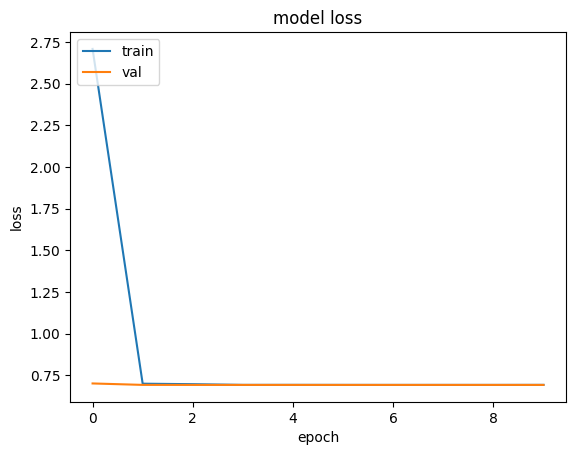

In [98]:
print(model.history.history.keys())
# summarize history for accuracy
plt.plot(model.history.history['loss'])
plt.plot(model.history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [93]:
embeddings = model.layers[0].get_weights()[0] # матрица со всеми эмбедингами

In [94]:
full_word_embeddings = np.zeros((len(tokenizer.fullword_vocab), 100)) # матрица с эмбедингами полных слов + нграммы
id2word = list(tokenizer.fullword_vocab)

for i, word in enumerate(tokenizer.fullword_vocab):
    subwords = tokenizer(word)[0]
    full_word_embeddings[i] = embeddings[[i for i in subwords]].mean(axis=0)

In [95]:
def most_similar_ft(word, embeddings, tokenizer):
    subwords = tokenizer(word)[0]
    word_embedding = embeddings[[i for i in subwords]].sum(axis=0)
    # idxs = [tokenizer.word2id[i] for i in tokenizer.fullword_vocab]
    similar = [id2word[i] for i in
               cosine_distances(word_embedding.reshape(1, -1), full_word_embeddings).argsort()[0][:20]]
    return similar

In [96]:
most_similar_ft('кошка', embeddings, tokenizer)

['кошка',
 'колчака',
 'кракове',
 'краеведческий',
 'показана',
 'краснодарский',
 'константиновский',
 'куколка',
 'коминтерна',
 'категорий',
 'доказательством',
 'мешка',
 'блошка',
 'порошка',
 'показан',
 'показатель',
 'проволокой',
 'белокалитвинский',
 'колумбийский',
 'конфликтом']

In [97]:
most_similar_ft('дружба', embeddings, tokenizer)

['дружба',
 'дружбы',
 'дружбе',
 'дружбу',
 'дружины',
 'дружина',
 'дружин',
 'друть',
 'дружеских',
 'дружинный',
 'друзей',
 'другую',
 'дружил',
 'других',
 'друга',
 'другая',
 'другое',
 'дружен',
 'дружеские',
 'другим']